<a href="https://colab.research.google.com/github/maximum4645/ComputerVision/blob/main/object_detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import random_split
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [2]:
# Define the transform
transform = T.Compose([T.ToTensor()])

# Download the dataset
dataset = torchvision.datasets.VOCDetection(root='.', year='2012', image_set='train', download=True, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
categories = ["__background__", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
              "dog", "horse", "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor"]
print('Number of train set :', len(train_set))
print('Number of test set :', len(test_set))
print('Number of classes :', len(categories))

100%|██████████| 1999639040/1999639040 [01:37<00:00, 20515336.40it/s]


Extracting ./VOCtrainval_11-May-2012.tar to .
Number of train set : 4573
Number of test set : 1144
Number of classes : 21


# Model

In [3]:
# Load the pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model to evaluation mode
model.eval()

# Number of classes in the Pascal VOC dataset (20 classes + background)
num_classes = 21

# Get the input features of the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Freeze all the layers in the backbone
for param in model.backbone.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 147MB/s]


# Prediction

## Getting dataloaders

In [4]:
# Define a custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

def get_dataloaders(train_set, test_set, transform, subset_size, val_size, batch_size):
    train_set.dataset.transform = transform
    test_set.dataset.transform = transform
    if subset_size:
        indices = torch.randperm(len(train_set))[:subset_size]
        train_subset = Subset(train_set, indices)
        train_size = int((1 - val_size) * subset_size)
        val_size = subset_size - train_size
        train_set, val_set = random_split(train_subset, [train_size, val_size])
    else:
        train_size = int((1 - val_size) * len(train_set))
        val_size = len(train_set) - train_size
        train_set, val_set = random_split(train_set, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

# Function to extract bounding boxes from target
def extract_boxes(target):
    boxes = []
    for obj in target['annotation']['object']:
        box = obj['bndbox']
        boxes.append([int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax'])])
    return boxes

def visualize_predictions(image, target, prediction):

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Ground truth
    ax[0].imshow(F.to_pil_image(image))
    for i, box in enumerate(extract_boxes(target)):
        ax[0].add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      fill=False, color='blue', linewidth=2))

        category_name = target['annotation']['object'][i]['name']
        ax[0].text(box[0], box[1] - 10, category_name, color='blue', fontsize=12, backgroundcolor='white')

    ax[0].set_title("Ground Truth")

    # Predictions
    ax[1].imshow(F.to_pil_image(image))
    for i, box in enumerate(prediction['boxes']):
        ax[1].add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      fill=False, color='red', linewidth=2))

        category_id = prediction['labels'][i].item()
        category_name = categories[category_id]
        ax[1].text(box[0], box[1] - 10, category_name, color='red', fontsize=12)

    ax[1].set_title("Predictions")

    plt.show()

In [5]:
# Define the transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
subset_size = 1000
val_size = 0.2

train_loader, val_loader, test_loader = get_dataloaders(
                                            train_set = train_set,
                                            test_set = test_set,
                                            transform = transform,
                                            subset_size = subset_size,
                                            val_size = val_size,
                                            batch_size = 8)

## Evaluation before training

In [16]:
# Function to apply NMS and filter predictions
def apply_nms(predictions, iou_threshold=0.5):
    # Perform Non-Maximum Suppression
    keep_indices = torchvision.ops.nms(predictions['boxes'], predictions['scores'], iou_threshold)
    predictions['boxes'] = predictions['boxes'][keep_indices]
    predictions['scores'] = predictions['scores'][keep_indices]
    predictions['labels'] = predictions['labels'][keep_indices]
    return predictions

def calculate_iou(box1, box2):
    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(box1Area + box2Area - interArea)

    return iou

def evaluate_model(model, data_loader, device, iou_threshold, eval_batches):
    model.eval()
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    batch_count = 0

    with torch.no_grad():
        for images, targets in data_loader:

            if batch_count >= eval_batches:
                break

            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

            # Make predictions
            predictions = model(images)

            for i in range(len(predictions)):
                # Apply NMS
                predictions[i] = apply_nms(predictions[i], iou_threshold)

                # Evaluate predictions
                pred_boxes = predictions[i]['boxes'].cpu()
                true_boxes = extract_boxes(targets[i])

                # Calculate true positives, false positives, false negatives
                for pred_box in pred_boxes:
                    if any([calculate_iou(pred_box, true_box) > iou_threshold for true_box in true_boxes]):
                        total_true_positives += 1
                    else:
                        total_false_positives += 1
                total_false_negatives += len(true_boxes) - total_true_positives

            print(f"{batch_count} / {eval_batches}")
            batch_count += 1

    precision = total_true_positives / (total_true_positives + total_false_positives)
    recall = total_true_positives / (total_true_positives + total_false_negatives)

    return precision, recall

In [17]:
device = torch.device('cpu')
model.to(device)

precision_before, recall_before = evaluate_model(model, test_loader, device, iou_threshold=0.5, eval_batches=5)
print(f"Precision before training: {precision_before:.4f}, Recall before training: {recall_before:.4f}")


0 / 5
1 / 5
2 / 5
3 / 5
4 / 5
Precision before training: 0.0302, Recall before training: -0.0520


## Visualization before training

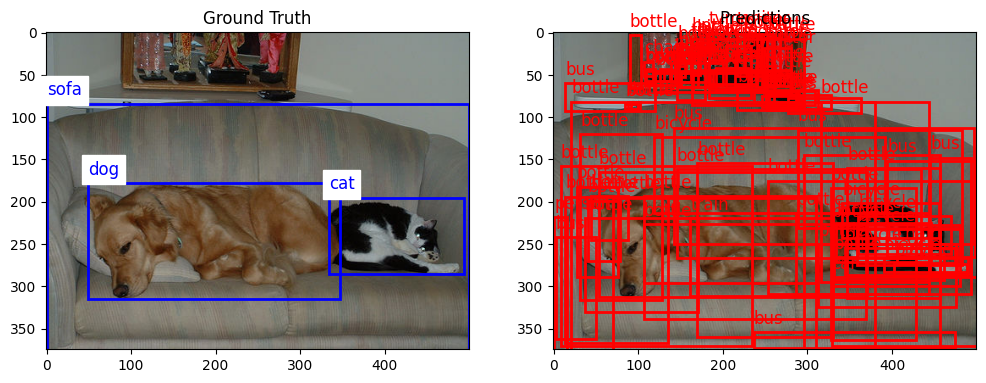

In [18]:
device = torch.device('cpu')
model.to(device)

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.5)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

## Training

In [19]:
# Function to extract boxes and labels from target

def get_boxes_and_labels(target):
    boxes = []
    labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(categories)}
    for obj in target['annotation']['object']:
        box = obj['bndbox']
        boxes.append([int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax'])])
        labels.append(class_to_idx[obj['name']])
    return {
        "boxes": torch.as_tensor(boxes, dtype=torch.float32),
        "labels": torch.as_tensor(labels, dtype=torch.int64)
    }

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define training parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# Set up the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler

# Training loop
loss_list = []
for epoch in range(num_epochs):
    model.train()
    i = 0
    epoch_loss = 0
    for images, targets in train_loader:
        # Move data to the appropriate device
        images = [image.to(device) for image in images]
        targets = [get_boxes_and_labels(t) for t in targets]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Compute losses
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

        if i % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 10}/{len(train_loader)}], Loss: {losses.item():.4f}")
        i += 1

    loss_list.append(epoch_loss / len(train_loader))
    # Update the learning rate
    lr_scheduler.step()

print("Training complete.")

Epoch [1/10], Step [10/100], Loss: 3.2371
Epoch [1/10], Step [20/100], Loss: 1.0526
Epoch [1/10], Step [30/100], Loss: 0.7378
Epoch [1/10], Step [40/100], Loss: 0.7805
Epoch [1/10], Step [50/100], Loss: 0.8191
Epoch [1/10], Step [60/100], Loss: 0.4475
Epoch [1/10], Step [70/100], Loss: 0.3766
Epoch [1/10], Step [80/100], Loss: 0.4234
Epoch [1/10], Step [90/100], Loss: 0.7080
Epoch [1/10], Step [100/100], Loss: 0.3214
Epoch [2/10], Step [10/100], Loss: 0.4794
Epoch [2/10], Step [20/100], Loss: 0.5675
Epoch [2/10], Step [30/100], Loss: 0.5334
Epoch [2/10], Step [40/100], Loss: 0.5121
Epoch [2/10], Step [50/100], Loss: 0.5542
Epoch [2/10], Step [60/100], Loss: 0.4277
Epoch [2/10], Step [70/100], Loss: 0.3819
Epoch [2/10], Step [80/100], Loss: 0.4128
Epoch [2/10], Step [90/100], Loss: 0.2403
Epoch [2/10], Step [100/100], Loss: 0.3158
Epoch [3/10], Step [10/100], Loss: 0.3666
Epoch [3/10], Step [20/100], Loss: 0.4673
Epoch [3/10], Step [30/100], Loss: 0.2310
Epoch [3/10], Step [40/100], Los

## Evaluation after training

In [20]:
device = torch.device('cpu')
model.to(device)

precision_before, recall_before = evaluate_model(model, test_loader, device, iou_threshold=0.5, eval_batches=5)
print(f"Precision before training: {precision_before:.4f}, Recall before training: {recall_before:.4f}")


0 / 5
1 / 5
2 / 5
3 / 5
4 / 5
Precision before training: 0.2898, Recall before training: -0.0544


## Visualization after training

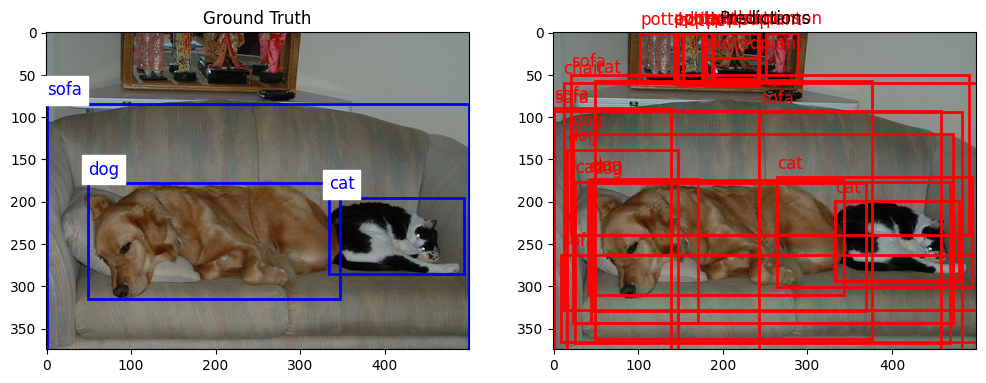

In [23]:
model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.8)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

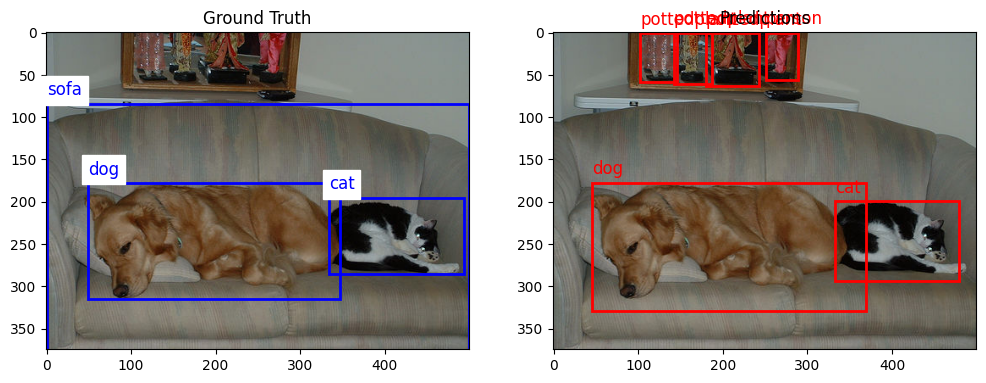

In [24]:
model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.1)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

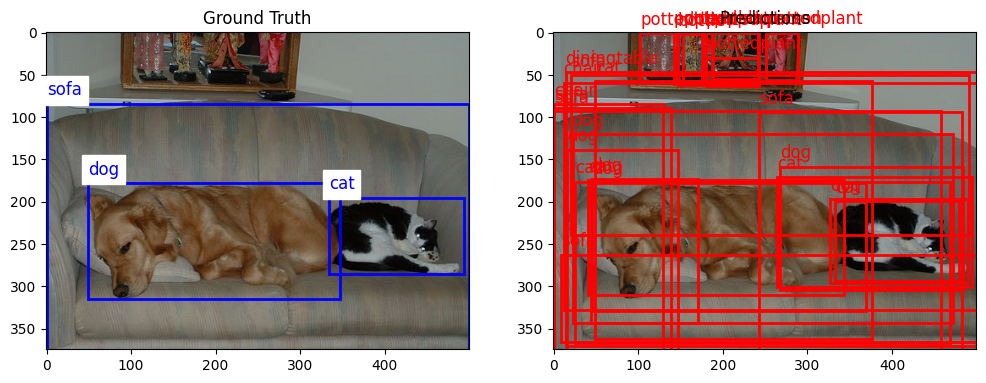

In [26]:
model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.95)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break